In [ ]:
# 에포크 1개 하자
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import time
import os
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_dir = '/content/drive/MyDrive'

In [ ]:
#이미지 변환을 할거면 여기다가 해보자
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(0.3),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
full_dataset = datasets.ImageFolder(os.path.join(data_dir, 'data'))

class_names = full_dataset.classes

In [ ]:
from torch.utils.data import ConcatDataset

train_size = int(0.6 * len(full_dataset))
test_size = int(0.2 * len(full_dataset))
valid_size = len(full_dataset) - train_size - test_size
train_dataset, valid_dataset, test_dataset = random_split(full_dataset,[train_size, valid_size, test_size])

# 첫 번째 데이터셋에 변환을 적용
train_dataset1 = train_dataset
train_dataset1.dataset.transform = data_transforms['train']

# 두 번째 데이터셋에는 변환을 적용하지 않음
train_dataset.dataset.transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 두 데이터셋을 합치기
train_dataset = ConcatDataset([train_dataset, train_dataset1])
train_loader = DataLoader(train_dataset, batch_size = 8, shuffle = True, num_workers = 0)
valid_loader = DataLoader(valid_dataset, batch_size = 8, shuffle = False, num_workers = 0)
test_loader = DataLoader(test_dataset, batch_size = 8, shuffle = False, num_workers = 0)

print(train_size, valid_size, test_size)

12838 4280 4279


In [ ]:
print(len(train_dataset))

25676


In [ ]:
print(class_names)

['Cassava___bacterial_blight', 'Cassava___brown_streak_disease', 'Cassava___green_mottle', 'Cassava___healthy', 'Cassava___mosaic_disease']


In [ ]:
print(train_loader.batch_size)

8


In [ ]:
print(len(full_dataset))

21397


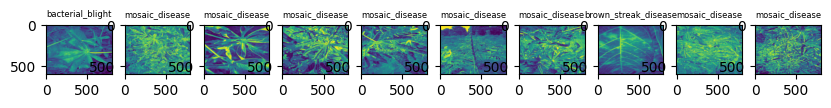

In [ ]:
import matplotlib.pyplot as plt
def image_show(dataset, num):
  fig = plt.figure(figsize = (10,10))

  for i in range(num):
    plt.subplot(1, num, i+1)
    plt.imshow(dataset[i][0][0])
    plt.title(class_names[dataset[i][1]].split('___')[1], fontsize=6)


image_show(train_dataset, 10)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
!nvidia-smi

cuda
Mon Sep 29 10:00:56 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   54C    P0             28W /   72W |    6799MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+

In [ ]:
num_classes = len(class_names)

model = models.mobilenet_v2(pretrained=True)
model.classifier[1] = torch.nn.Linear(model.last_channel, num_classes)

In [ ]:
model = model.to(device)
print(model)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.00005, weight_decay = 0.1)
# step_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 3, gamma = 0.5)

num_epochs = 1

In [ ]:
tr_loss = []
tr_acc = []
v_loss = []
v_acc = []
best_valid_loss = torch.inf
best_epoch = 0
for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    print('-' * 10)
    for phase in ['train', 'valid']:
        if phase == 'train':
            dataloader = train_loader
            model.train()
        else:
            dataloader = valid_loader
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in tqdm(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        #if phase == 'train':
            #step_lr_scheduler.step()

        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_acc = (running_corrects.float() / len(dataloader.dataset)).detach().cpu()


        print('{} Loss: {:.4f} Acc: {:.4f}'.format(
            phase, epoch_loss, epoch_acc))
        if phase == 'train':
          tr_loss.append(epoch_loss)
          tr_acc.append(epoch_acc)
        elif phase == 'valid':
          v_loss.append(epoch_loss)
          v_acc.append(epoch_acc)
          if epoch_loss < best_valid_loss:
            best_valid_loss = epoch_loss
            best_epoch = epoch
            torch.save(model.state_dict(), "parrot_team1.pth")

print('Training complete')
print("Best epoch is",best_epoch+1)

Epoch 1/1
----------


100%|██████████| 3210/3210 [3:03:48<00:00,  3.44s/it]


train Loss: 0.5883 Acc: 0.7957


100%|██████████| 535/535 [59:34<00:00,  6.68s/it]

valid Loss: 0.4997 Acc: 0.8339
Training complete
Best epoch is 1


In [ ]:
# 저장된 모델 불러오기
model.load_state_dict(torch.load("parrot_team1.pth"))
model.eval()

# 테스트 진행
test_running_loss = 0.0
test_running_corrects = 0

for inputs, labels in tqdm(test_loader):
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

    test_running_loss += loss.item() * inputs.size(0)
    test_running_corrects += torch.sum(preds == labels.data)

# 테스트 결과 출력
test_loss = test_running_loss / len(test_loader.dataset)
test_acc = (test_running_corrects.float() / len(test_loader.dataset)).detach().cpu()

print('Test Loss: {:.4f} Acc: {:.4f}'.format(test_loss, test_acc))


100%|██████████| 535/535 [1:00:26<00:00,  6.78s/it]

Test Loss: 0.5119 Acc: 0.8201
